# Lesson5 画像からキャプションを生成してみよう

## 目次
- Section 2 実装①
    - 2.0 データの用意
    - 2.1 モデル構築
    - 2.2 モデルの学習
    - 2.3 モデルによる予測
    - 2.4 パラメータの保存

## 1.5の解答
問1: ①

## Section 2 実装①

MS-COCOのデータセットでキャプション生成を実際に行ってみましょう。

### 2.0 データの準備

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_data(file_path, tokenizer = None):
    whole_texts = []
    for line in open(file_path, encoding='utf-8'):
        whole_texts.append("<s> " + line.strip() + " </s>")
        
    if tokenizer == None :
        tokenizer = Tokenizer(filters="")
        tokenizer.fit_on_texts(whole_texts)
    
    return tokenizer.texts_to_sequences(whole_texts), tokenizer

x_train = np.load('/content/gdrive/MyDrive/dl4us/dl4us-master/lesson5/data/x_train.npy')
x_valid = np.load('/content/gdrive/MyDrive/dl4us/dl4us-master/lesson5/data/x_valid.npy')

# 読み込み＆Tokenizerによる数値化
y_train, tokenizer_train = load_data('/content/gdrive/MyDrive/dl4us/dl4us-master/lesson5/data/y_train.txt')
y_valid, _ = load_data('/content/gdrive/MyDrive/dl4us/dl4us-master/lesson5/data/y_valid.txt', tokenizer_train)

vocab_size = len(tokenizer_train.word_index) + 1

# パディング
y_train = pad_sequences(y_train, padding='post')
y_valid = pad_sequences(y_valid, padding='post')

caption_len = len(y_train[0])

### 2.1 モデル構築

#### Encoder

今回は学習時間・難易度の観点からEncoderのパラメータについてはVGG16のものをそのまま流用し、改めてチューニングは行わないことにします。

余力のある方は、パラメータを固定せずに全体を学習することを試みてもよいかもしれません。

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Flatten, Lambda
from tensorflow.keras.applications.vgg16 import VGG16

K.clear_session()

encoder_input = Input(shape=(224, 224, 3))
encoder_input_normalized = Lambda(lambda x: x / 255.)(encoder_input) # [0, 255) -> [0, 1)
encoder = VGG16(weights='imagenet', include_top=False, input_tensor=encoder_input_normalized)

# パラメータを固定
for layer in encoder.layers:
    layer.trainable = False

# CNNの出力
u = Flatten()(encoder.output)

58892288/58889256 [==============================] - 0s 0us/step


#### Decoder

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, LSTM

emb_dim = 128
hid_dim = 128

# LSTMの初期状態
decoded_states = [Dense(hid_dim)(u), Dense(hid_dim)(u)] # h_0、c_0 に対応

# 層の定義
decoder_input = Input(shape=(caption_len,))
embedding = Embedding(vocab_size, emb_dim, mask_zero=True)
lstm = LSTM(hid_dim, activation='tanh', return_sequences=True, return_state=True)
dense = Dense(vocab_size, activation='softmax')

# 層の接続
decoder_embedded = embedding(decoder_input)
decoder_output, _, _ = lstm(decoder_embedded, initial_state=decoded_states) # 第2、3戻り値(最終ステップのh、c)は無視
decoder_pred = dense(decoder_output)

#### model化

In [ ]:
from tensorflow.keras.models import Model

model = Model([encoder_input, decoder_input], decoder_pred)
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

### 2.2 モデルの学習

In [ ]:
import numpy as np

train_target = np.hstack((y_train[:, 1:], np.zeros((len(y_train),1), dtype=np.int32)))

model.fit([x_train, y_train], np.expand_dims(train_target, -1), batch_size=64, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
625/625 [==============================] - 226s 361ms/step - loss: 0.9477 - val_loss: 0.8874
Epoch 2/5
625/625 [==============================] - 225s 360ms/step - loss: 0.7907 - val_loss: 0.8190
Epoch 3/5
625/625 [==============================] - 225s 360ms/step - loss: 0.7386 - val_loss: 0.7947
Epoch 4/5
625/625 [==============================] - 225s 360ms/step - loss: 0.7061 - val_loss: 0.7752
Epoch 5/5
625/625 [==============================] - 226s 361ms/step - loss: 0.6840 - val_loss: 0.7637


### 2.3 モデルによる生成

実際にキャプション生成をvalidationデータに対して行いたいと思いますが、基本的な考え方は翻訳モデルと大差なく、入力が画像に変わるだけです。

なお、decoderでキャプションを生成する際は、最初の単語として`<s>`を入力するのでした。

その後各ステップで最大の確率を示す単語を採用し、次ステップの入力としていきます。

最終的に終端記号`</s>`が排出されるか、もしくは予めきめておいた`max_len`に到達するまでdecodeしていきます。

In [ ]:
# サンプリング用（生成用）のモデルを作成

# 符号化器（学習時と同じ構成、学習したレイヤーを利用）
encoder_model = Model(encoder_input, decoded_states)

# 復号化器
decoder_states_inputs = [Input(shape=(hid_dim,)), Input(shape=(hid_dim,))] # decorder用lstmの初期状態指定用(h_t、c_t)

decoder_input = Input(shape=(1,))
decoder_embedded = embedding(decoder_input) # 学習済みEmbeddingレイヤーを利用
decoder_output, *decoder_states = lstm(decoder_embedded, initial_state=decoder_states_inputs) # 学習済みLSTMレイヤーを利用
decoder_pred = dense(decoder_output) # 学習済みDenseレイヤーを利用

decoder_model = Model([decoder_input] + decoder_states_inputs, [decoder_pred] + decoder_states)

In [ ]:
def decode_sequence(input_image, bos_eos, max_output_length = 100):
    states = encoder_model.predict(input_image)

    target_seq = np.array(bos_eos[0])  # bos_eos[0]="<s>"に対応するインデックス
    output_seq= bos_eos[0]
    
    while True:
        token_dist, *states = decoder_model.predict([target_seq] + states)
        sampled_token_index = [np.argmax(token_dist[0, -1, :])]
        output_seq += sampled_token_index
        
        if (sampled_token_index == bos_eos[1] or len(output_seq) > max_output_length):
            break

        target_seq = np.array(sampled_token_index)

    return output_seq

<s> a man is riding a bike on a bike . </s>


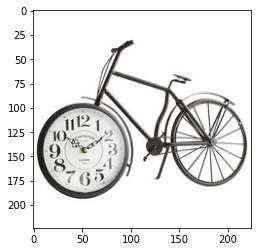

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

bos_eos = tokenizer_train.texts_to_sequences(["<s>", "</s>"])
detokenizer_train = dict(map(reversed, tokenizer_train.word_index.items()))

x_test = np.array(x_valid[:1])

y_pred = decode_sequence(x_test, bos_eos)

print(' '.join([detokenizer_train[i] for i in y_pred]))

plt.imshow(x_test[0])

### 2.4 パラメータの保存

In [ ]:
import os

def save_model(model, name):
    data_dir = '/content/gdrive/MyDrive/dl4us/dl4us-master/lesson5/data'
    if not os.path.isdir(data_dir):
        os.makedirs(data_dir)
    result_dir = os.path.normpath(data_dir)
    model.save_weights(os.path.join(result_dir, name + '_model.h5'))
    
def load_weight(model, name):
    data_dir = '/content/gdrive/MyDrive/dl4us/dl4us-master/lesson5/data'
    result_dir = os.path.normpath(data_dir)
    weight_file = os.path.join(result_dir, name + '_model.h5')
    model.load_weights(weight_file)
    return model

In [ ]:
# save model
save_model(model, 'image2text')

In [ ]:
# load weight
if os.path.exists('data/image2text_model.h5'):
    model = load_weight(model, 'image2text')